# Estimated potential scale reduction ($\hat{R}$)
author: @karm-patel

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns
import numpy as np

try:
    from probml_utils import latexify, savefig
except ModuleNotFoundError:
    %pip install git+https://github.com/probml/probml-utils.git
    from probml_utils import latexify, savefig

from probml_utils.blackjax_utils import inference_loop_multiple_chains, arviz_trace_from_states

try:
    import tensorflow_probability.substrates.jax as tfp
except ModuleNotFoundError:
    %pip -qq install tensorflow_probability
    import tensorflow_probability.substrates.jax as tfp

try:
    import blackjax
except ModuleNotFoundError:
    %pip install -qq blackjax
    import blackjax

tfd = tfp.distributions

We calculate $\hat{R}$ using following equations, which is given in book2, section 11.6.2.2
\begin{align}
  B &= \frac{N}{M-1} \sum_{m=1}^M (\overline{x}_{\cdot m}
  - \overline{x}_{\cdot \cdot})^2,
  \text{ where }
  \overline{x}_{\cdot m} = \frac{1}{N} \sum_{n=1}^N x_{nm},
  \; \;
  \overline{x}_{\cdot \cdot} = \frac{1}{M} \sum_{m=1}^M \overline{x}_{\cdot m} &= eq (1) \\ 
  W &= \frac{1}{M} \sum_{m=1}^M s_m^2,
    \text{ where }
    s_m^2 = \frac{1}{N-1} \sum_{n=1}^N (x_{nm}-\overline{x}_{\cdot m})^2  &= eq (2) \\
  \hat{V}^{+} &= \frac{N-1}{N} W + \frac{1}{N} B  &= eq (3)  \\
  \hat{R} &= \sqrt{ \frac{\hat{V}^{+}}{W} } &= eq (4) 
\end{align}

In [2]:
def calculate_non_split_R_hat(samples):
    n_samples = len(samples)
    n_chains = samples.shape[1]

    # B (between) is variance of mean of individual chains, but scaled up to n_samples
    B = jnp.var(samples.mean(axis=0), ddof=1) * n_samples / n_chains  # eq(1),

    # W (within sequence) is mean of variance of individual chain
    W = jnp.var(samples, axis=0, ddof=1).mean()  # eq(2),

    # conservative estimate estimate of true variance (V)
    v_plus = (B + (n_samples - 1) * W) / n_samples  # eq (3)

    # R_hat
    R_hat = jnp.sqrt(v_plus / W)  # eq (4)
    print(f"B={B}\nW={W}\nv_plus={v_plus}")
    return R_hat


calculate_split_R_hat = lambda samples: np.round(az.rhat(np.array(np.swapaxes(samples, 0, 1))), 3)

In [3]:
# import os
# os.environ["LATEXIFY"] = ""
# os.environ["FIG_DIR"] = "figures"

In [4]:
latexify(width_scale_factor=3, fig_height=1.8)

/home/patel_karm/probml-utils/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


## Bimodal distribution
we will take samples from bimodal distribution using HMC algorithm

/home/patel_karm/probml-utils/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


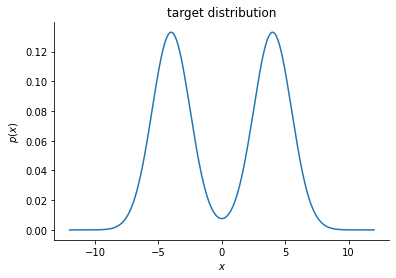

In [5]:
loc = 4.0
locs = jnp.array([-loc, loc])
scales = jnp.array([1.5, 1.5])
norm_mix = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=[0.5, 0.5]), components_distribution=tfd.Normal(loc=locs, scale=scales)
)

fig = plt.figure()
ax = plt.gca()
x = jnp.linspace(-loc - 8, loc + 8, 1000)
ax.plot(x, norm_mix.prob(x))
ax.set_xlabel("$x$")
ax.set_ylabel("$p(x)$")
ax.set_title("target distribution")
sns.despine()
savefig("rhat_bimodal_dist", pad_inches=0.25)

## Stationary chains but not mixing up

In [6]:
N_CHAINS = 2
N_SAMPLES = 1000
COLORS = ["tab:red", "tab:green"]

In [7]:
step_size = 0.05
inverse_mass_matrix = jnp.array([0.8])
integration_step_size = 13
hmc = blackjax.hmc(
    norm_mix.log_prob,
    step_size=step_size,
    inverse_mass_matrix=inverse_mass_matrix,
    num_integration_steps=integration_step_size,
)
kernel = jax.jit(hmc.step)

In [8]:
initial_positions = jnp.array([-loc - 1, loc + 1])
initial_states = jax.vmap(hmc.init)(initial_positions)
initial_states

HMCState(position=DeviceArray([-5.,  5.], dtype=float32), potential_energy=DeviceArray([2.2397728, 2.2397728], dtype=float32), potential_energy_grad=DeviceArray([-0.44444442,  0.44444442], dtype=float32))

In [9]:
seed = 18
states, info = inference_loop_multiple_chains(
    jax.random.PRNGKey(seed=seed), kernel, initial_states, N_SAMPLES, N_CHAINS
)

In [10]:
samples = states.position
rhat = calculate_non_split_R_hat(samples)
rhat_split = calculate_split_R_hat(samples)

B=17303.185546875
W=1.6774184703826904
v_plus=18.978925704956055


/home/patel_karm/probml-utils/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


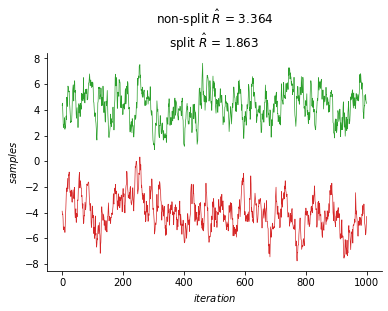

In [11]:
fig = plt.figure()
ax = plt.gca()

for i in range(N_CHAINS):
    ax.plot(samples[:, i], lw=0.7, c=COLORS[i])
ax.set_title("non-split $\hat{R}$ = " + f"{rhat:.3f}" + "\nsplit $\hat{R}$ = " + f"{rhat_split:.3f}")
# ax.set_title("$\hat{R}$ = " + f"{rhat:.3f}" +  "\nsplit-$\hat{R}$: "+ f"{rhat_split}");
ax.set_xlabel("$iteration$")
ax.set_ylabel("$samples$")
sns.despine()

savefig("rhat_stationarity_passed", tight_layout=True, pad_inches=0.25)

In [12]:
trace = arviz_trace_from_states(states, info)
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
samples,0.154,4.358,-5.848,6.386,2.958,2.463,3.0,114.0,1.86


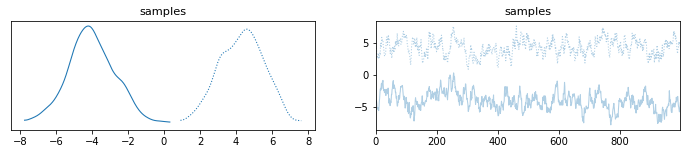

In [13]:
az.plot_trace(trace);

## Mixing chains but non stationary

In [14]:
step_size = 0.1
inverse_mass_matrix = jnp.array([0.1])
integration_step_size = 13
hmc = blackjax.hmc(
    norm_mix.log_prob,
    step_size=step_size,
    inverse_mass_matrix=inverse_mass_matrix,
    num_integration_steps=integration_step_size,
)
kernel = jax.jit(hmc.step)

In [15]:
initial_positions = jnp.array([-4.0, 4.0])
initial_states = jax.vmap(hmc.init)(initial_positions)
initial_states

HMCState(position=DeviceArray([-4.,  4.], dtype=float32), potential_energy=DeviceArray([2.0175502, 2.0175502], dtype=float32), potential_energy_grad=DeviceArray([-2.3674133e-06,  2.3674133e-06], dtype=float32))

In [16]:
seed = 98
states, info = inference_loop_multiple_chains(jax.random.PRNGKey(seed=seed), kernel, initial_states, 1000, 2)

In [17]:
samples = states.position
rhat = calculate_non_split_R_hat(samples)
rhat_split = calculate_split_R_hat(samples)

B=83.5451431274414
W=10.955224990844727
v_plus=11.027814865112305


/home/patel_karm/probml-utils/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


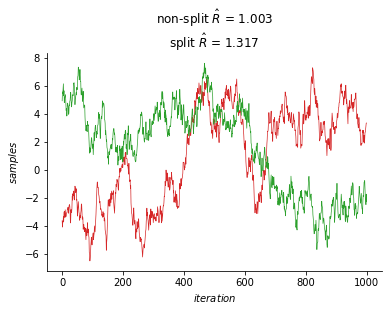

In [18]:
fig = plt.figure()
ax = plt.gca()

for i in range(N_CHAINS):
    ax.plot(samples[:, i], lw=0.7, c=COLORS[i])
ax.set_title("non-split $\hat{R}$ = " + f"{rhat:.3f}" + "\nsplit $\hat{R}$ = " + f"{rhat_split:.3f}")
# ax.set_title("$\hat{R}$ = " + f"{rhat:.3f}" +  "\nsplit-$\hat{R}$: "+ f"{rhat_split}");
ax.set_xlabel("$iteration$")
ax.set_ylabel("$samples$")
sns.despine()

savefig("rhat_stationarity_failed", pad_inches=0.25)

In [19]:
trace = arviz_trace_from_states(states, info)
smry = az.summary(trace)
smry

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
samples,1.237,3.322,-4.498,6.117,1.634,1.248,5.0,70.0,1.32


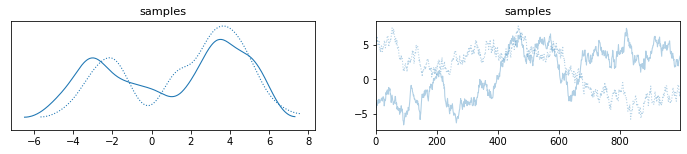

In [20]:
az.plot_trace(trace);